# DEMO

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

### Installing the required libraries and versions

In [ ]:
! conda env create -n BCM_D2K_env -f environment.yml

In [3]:
# run the below line in your terminal
# ! conda activate BCM_D2K_env

# Part 1: Data Cleaning and Preprocessing


### First we clean the student data. The data must be run through clean_student_data_first.RMD before the code block below is run.

In [ ]:
from cleaning_preprocessing.clean_student_data_second import *


# After running the R script, finish the rest of the prepocessing, creating columns we need for modeling
student_data = clean_student_data(local_dir ='./data_directory')
student_data.reset_index(inplace=True)

# Part 2: Modeling

## 2.1 K Means Time Series Clustering



#### We attempt to group students into trajectory group clusters based on their probability of being classified as overweight/obese. This is operationalized as each of 11 BMI measurements being above or below the 85th percentile, relative to the national population.

In [2]:
import modeling.kmeans_ts_clustering.kmeans_ts_clustering as kmeans

# get BMIz time series
# the variable bmiz stores time series of BMI z-scores for each student
bmiz = kmeans.bmiz_time_series(student_data)

# get bmipbool time series
# the variable bmipbool stores time series of whether the BMI percentile
# >= 85th (indicating overweight/obese) for each student
bmipbool = kmeans.bmipbool_time_series(student_data)

# add columns of bmiz changes, bmi changes, and bmi percentage changes
kmeans.add_changes_columns(student_data)

# export dataset with added columns to data directory
student_data.to_csv("../../data_directory/student_data_cleaned.csv", index = False)

In [4]:
# will need to convert the 2d dataframe into a list of rows to fit the plotting function
# the variables below are just 2d list representations of the variables mentioned above

# convert bmipbool columns to a list
bmipbool_to_list = kmeans.dataframe_to_list(bmipbool)

# convert bmiz columns to a list
bmiz_to_list = kmeans.dataframe_to_list(bmiz)

# convert change in bmiz columns to a list
chg_bmiz_to_list = kmeans.dataframe_to_list(student_data.loc[:, 'chg_bmiz_1':'chg_bmiz_10'])

# convert percent change in bmi columns to a list
percent_chg_bmi_to_list = kmeans.dataframe_to_list(student_data.loc[:, 'percent_chg_bmi_1':'percent_chg_bmi_10'])

# convert change in bmi columns to a list
chg_bmi_to_list = kmeans.dataframe_to_list(student_data.loc[:, 'chg_bmi_1':'chg_bmi_10'])

#### We use this function to find out what number of clusters will be the best fit for our data.

In [5]:
# optimal k using whether being overweight/obese as the outcome variable
# since k=6 includes clusters with  < 5 percent of the data, we choose 5 as our optimal
bmipbool_k = kmeans.choose_num_clusters(bmipbool.values, 
                                        student_data, 
                                        seed=0)
bmipbool_k

BIC with 2 clusters: -661.1442932641631
BIC with 3 clusters: -598.0414384711783
BIC with 4 clusters: -435.746849404162
BIC with 5 clusters: -380.8547718577
BIC with 6 clusters: -367.36372541529704


5

#### Using the Silhouette Score, we find that using Euclidian distance would give us better-defined clusters than Dynamic Time-Warping.

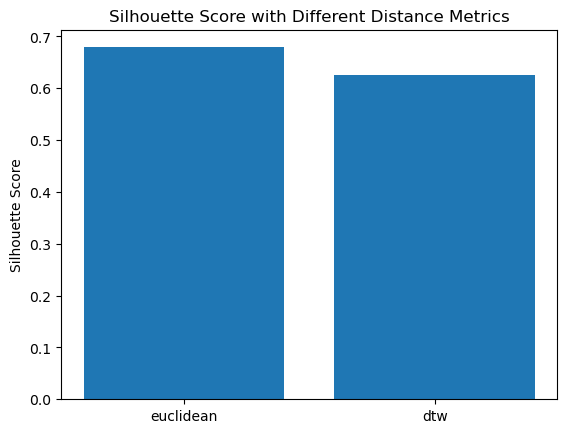

In [6]:
# test for comparing distance metrics
kmeans.compare_dist_metric(bmipbool_k, bmipbool, 
                           dist_metric = ['euclidean', 'dtw'], 
                           seed=0)

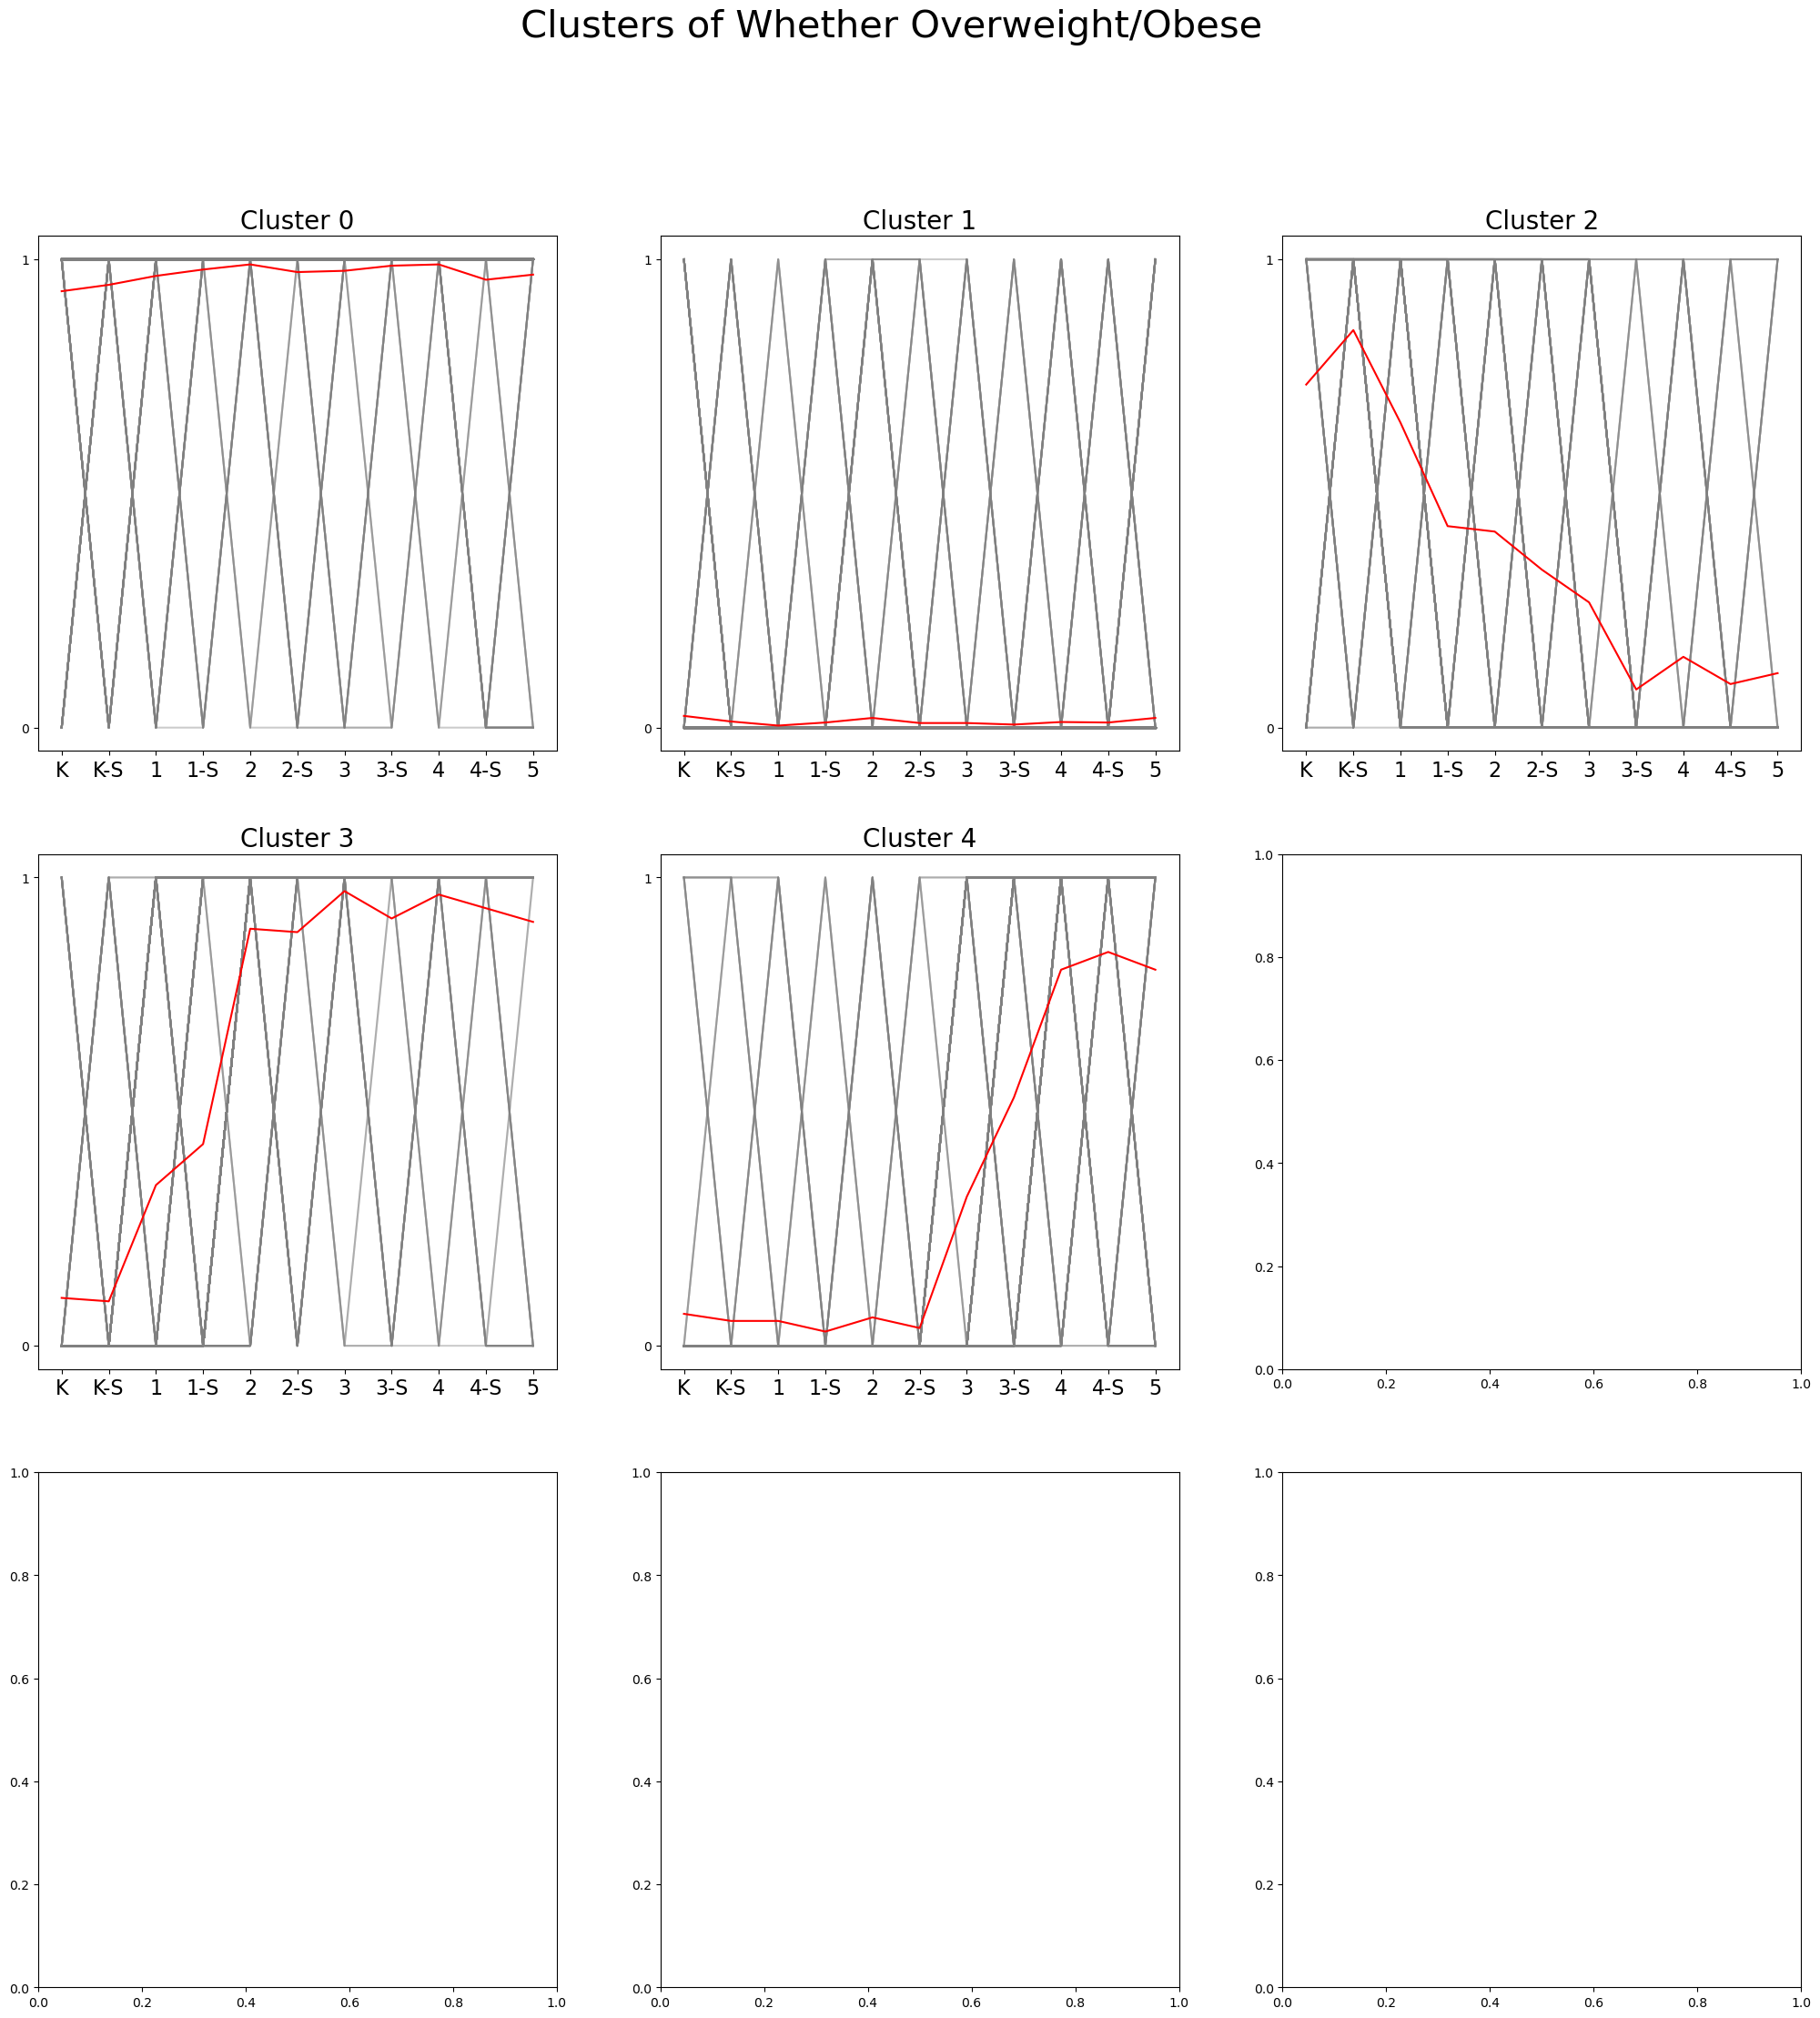

In [7]:
# test clustering plots using whether being overweight/obese as the outcome variable
bmipbool_labels = kmeans.plot_kmeans_ts_clustering(bmipbool_to_list, 
                                                   "Whether Overweight/Obese", 
                                                   bmipbool_k,
                                                   dist_metric='euclidean')


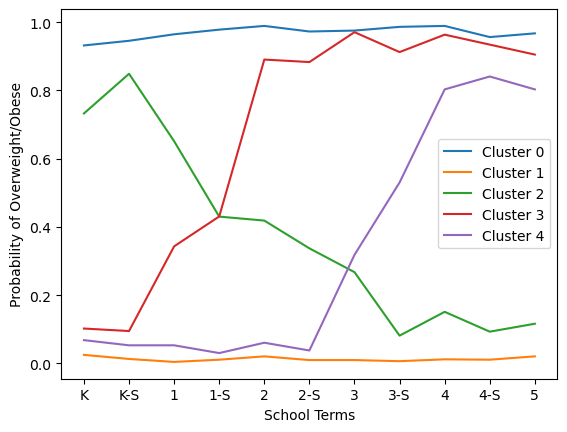

In [8]:
# plot the probability of being overweight/obese over time for the generated clusters
kmeans.plot_prob_overweight_for_clusters(bmipbool_k, bmipbool_labels, student_data)

In [9]:
# Evaluate the performance of the model across different distance metrics using silhouette scores.
# NOTE: This may take several minutes to run
dist_metric_evals = kmeans.tune_dist_metric(bmipbool, bmipbool_k, 
                                            dist_metric=['euclidean', 'dtw'], 
                                            seed=np.arange(100))

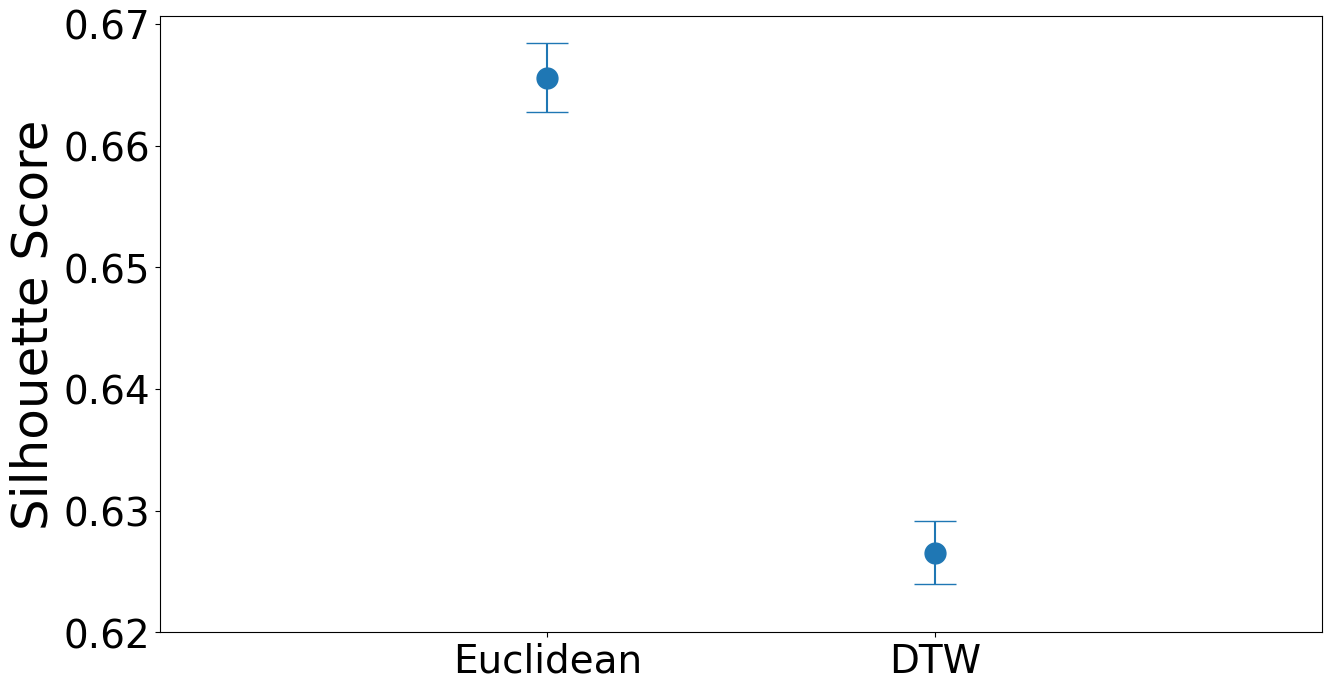

The average silhouette score using euclidean distance is 0.666, with a 95% confidence interval [0.663, 0.668].
The average silhouette score using DTW is 0.627, with a 95% confidence interval [0.624, 0.629].


In [10]:
# Plot the mean silhouette scores with 95% confidence intervals across different 
# distance metrics to visualize which distance metric performs the best. 
kmeans.plot_dist_metric_tunning(dist_metric_evals)

In [11]:
# Evaluate the performance of the model across different methods for the initialization of centroids.
init_evals = kmeans.tune_initialization(bmipbool, 
                                        bmipbool_k, 
                                        dist_metric='euclidean', 
                                        seed=np.arange(100))

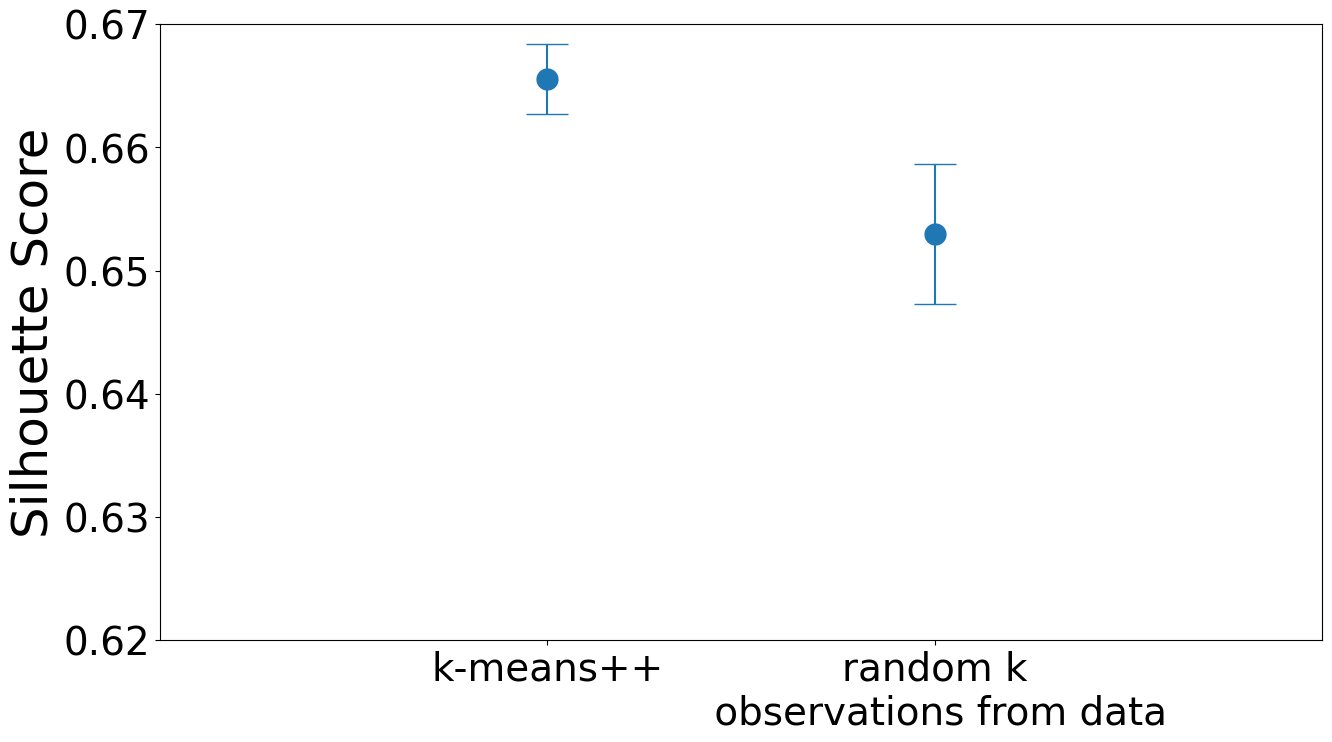

The average silhouette score using k-means++ is 0.666, with a 95% confidence interval [0.663, 0.668].
The average silhouette score using random k observations from data is 0.653, with a 95% confidence interval [0.647, 0.659].


In [12]:
# Plot the mean silhouette scores with 95% confidence intervals across different 
# initialization methods to visualize which method performs the best.
kmeans.plot_initialization_tunning(init_evals)

# The optimal hyperparameters for K-means Time Series Clustering:
### K = 5 (the number of clusters), distance metric = 'euclidean', and init = 'k-means++' (initialization method).

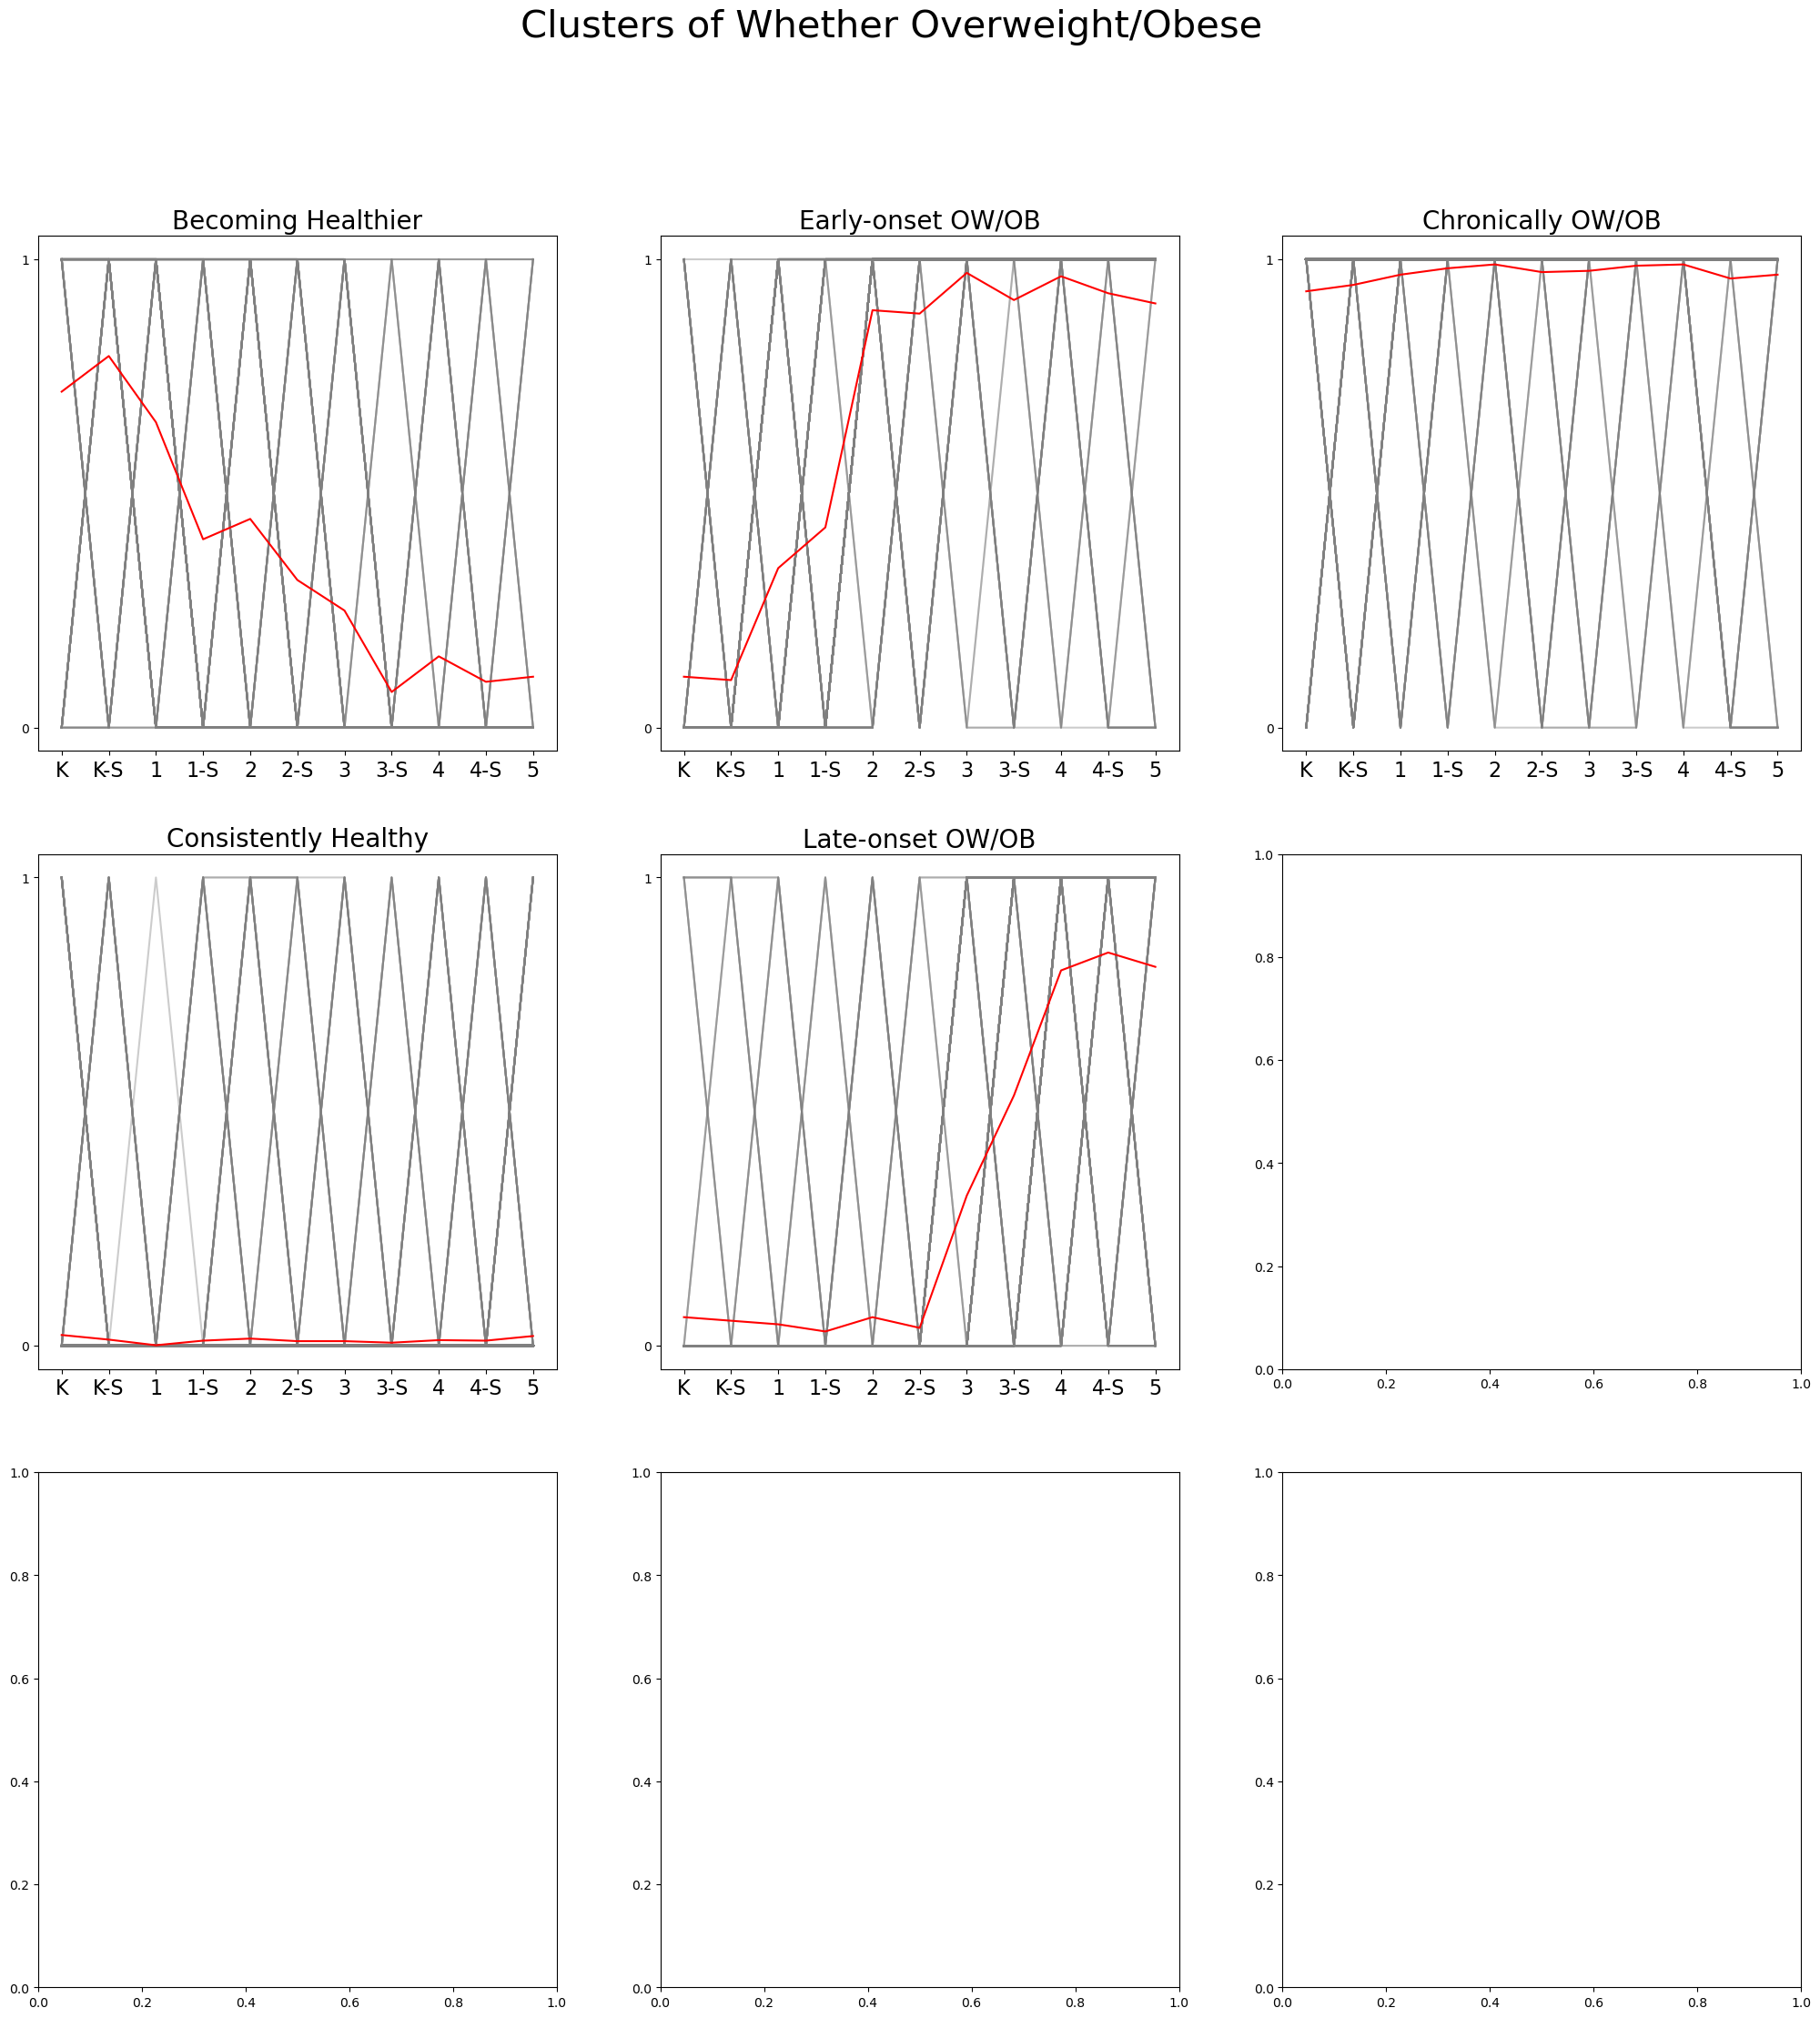

In [13]:
# retrain the model using the tuned parameters and the fixed seed 99 for reproducibility
cluster_labels = kmeans.plot_kmeans_ts_clustering(bmipbool_to_list, 
                                                  "Whether Overweight/Obese",
                                                  num_clusters=5,
                                                  dist_metric='euclidean', 
                                                  seed=99, 
                                                  cluster_names=kmeans.TRAJGPS)

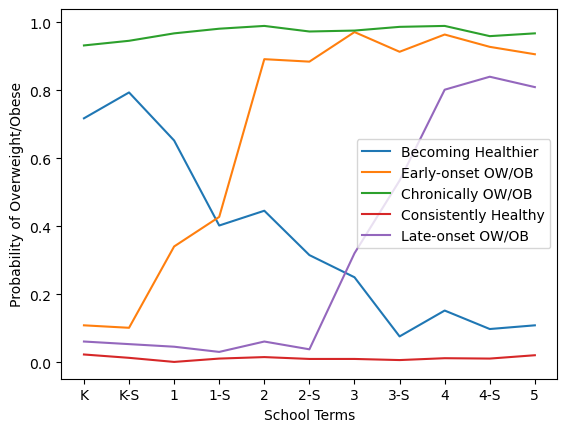

In [14]:
# plot the probability of being overweight/obese over time for the tuned clusters
kmeans.plot_prob_overweight_for_clusters(num_clusters=5, 
                                         labels=cluster_labels, 
                                         dataset=student_data, 
                                         cluster_names=kmeans.TRAJGPS)

# Now we want to compare the membership percentages between k-means and GBTM # 
### We noticed that there is a distinct difference in membership percentages in the 'Becoming Healthier' group, with k-means at 5.6\% and GBTM at 8.1\% ###

In [15]:
# Calculate k-means group membership percentages
kmeans.cluster_membership_percent_kmeans(student_data)

{'Becoming Healthier': 5.602923264311815,
 'Early-onset OW/OB': 8.404384896467722,
 'Chronically OW/OB': 22.289890377588307,
 'Consistently Healthy': 55.72472594397077,
 'Late-onset OW/OB': 7.978075517661389}

In [16]:
# Map GBTM membership labels to k-means membership labels to maintain consistency for comparison.
kmeans.map_group_cluster(student_data)

In [17]:
# Calculate GBTM group membership percentages
kmeans.cluster_membership_percent_gbtm(student_data)

{'Becoming Healthier': 8.099878197320342,
 'Early-onset OW/OB': 7.978075517661389,
 'Chronically OW/OB': 21.315468940316688,
 'Consistently Healthy': 53.836784409257,
 'Late-onset OW/OB': 8.76979293544458}

# We would like to validate the accuracy of the clustering performance of the two models #

### We define the accuracy metric as follows: ###
$$
\text{Individual Accuracy} = \begin{cases}
1 &\text{if its residual is within 2 standard deviations away from its center} \\
0 &\text{otherwise}
\end{cases}
$$ 


### We prepared relevant data of k-means and GBTM for calculating the accuracy ###

In [18]:
# get a list of observations' distance from k-means centroids by cluster 
kmeans_dist_from_center_per_cluster = kmeans.dist_from_center_by_cluster(student_data)[0]

# get k-means mean deviation (Euclidean distance) from centers for each cluster
kmeans_mean_dist_per_cluster = kmeans.kmeans_mean_dist_by_cluster(kmeans_dist_from_center_per_cluster)

# get k-means cluster sizes 
kmeans_cluster_size = kmeans.kmeans_cluster_sizes(kmeans_dist_from_center_per_cluster)

# get k-means standard deviation per cluster
kmeans_std_per_cluster = kmeans.kmeans_std_by_cluster(kmeans_dist_from_center_per_cluster, 
                                                      kmeans_mean_dist_per_cluster, 
                                                      kmeans_cluster_size)

# get a list of observations' distance from GBTM centroids by cluster 
gbtm_dist_from_center_per_cluster = kmeans.dist_from_center_by_cluster(student_data)[1]

# get GBTM mean deviation (Euclidean distance) from centers for each cluster
gbtm_mean_dist_per_cluster = kmeans.gbtm_mean_dist_by_cluster(gbtm_dist_from_center_per_cluster)

# get GBTM cluster sizes 
gbtm_cluster_size = kmeans.gbtm_cluster_sizes(gbtm_dist_from_center_per_cluster)

# get GBTM standard deviation per cluster
gbtm_std_per_cluster = kmeans.gbtm_std_by_cluster(gbtm_dist_from_center_per_cluster, 
                                                  gbtm_mean_dist_per_cluster, 
                                                  gbtm_cluster_size)


### Now we are able to calculate the clustering accuracy of the two models across both the entire dataset and individual groups ###

#### From the table, we can see that k-means has a slightly higher overall accuracy than GBTM, with superior accuracy in individual trajectory groups except for the "Early-onset Overweight/Obese" group. ####

In [19]:
# get k-means overall accuracy and accuracy by cluster
kmeans_accuracy = kmeans.kmeans_accuracy(kmeans_dist_from_center_per_cluster, 
                                         kmeans_mean_dist_per_cluster, 
                                         kmeans_std_per_cluster, 
                                         kmeans_cluster_size, student_data)

# get GBTM overall accuracy and accuracy by cluster
gbtm_accuracy = kmeans.gbtm_accuracy(gbtm_dist_from_center_per_cluster, 
                                     gbtm_mean_dist_per_cluster, 
                                     gbtm_std_per_cluster, 
                                     gbtm_cluster_size, student_data)

# display the accuracy table
kmeans.accuracy_table(kmeans_accuracy, gbtm_accuracy)



,Overall Accuracy (%),Becoming Healthier Accuracy (%),Early-onset OW/OB Accuracy (%),Chronically OW/OB Accuracy (%),Consistently Healthy Accuracy (%),Late-onset OW/OB Accuracy (%)
Method,,,,,,
K-Means,0.952497,0.945652,0.934783,0.967213,0.950820,0.946565
GBTM,0.950670,0.932331,0.946565,0.965714,0.950226,0.937500


# Finally, we plotted a comparison of trajectory groups between k-means and GBTM. #

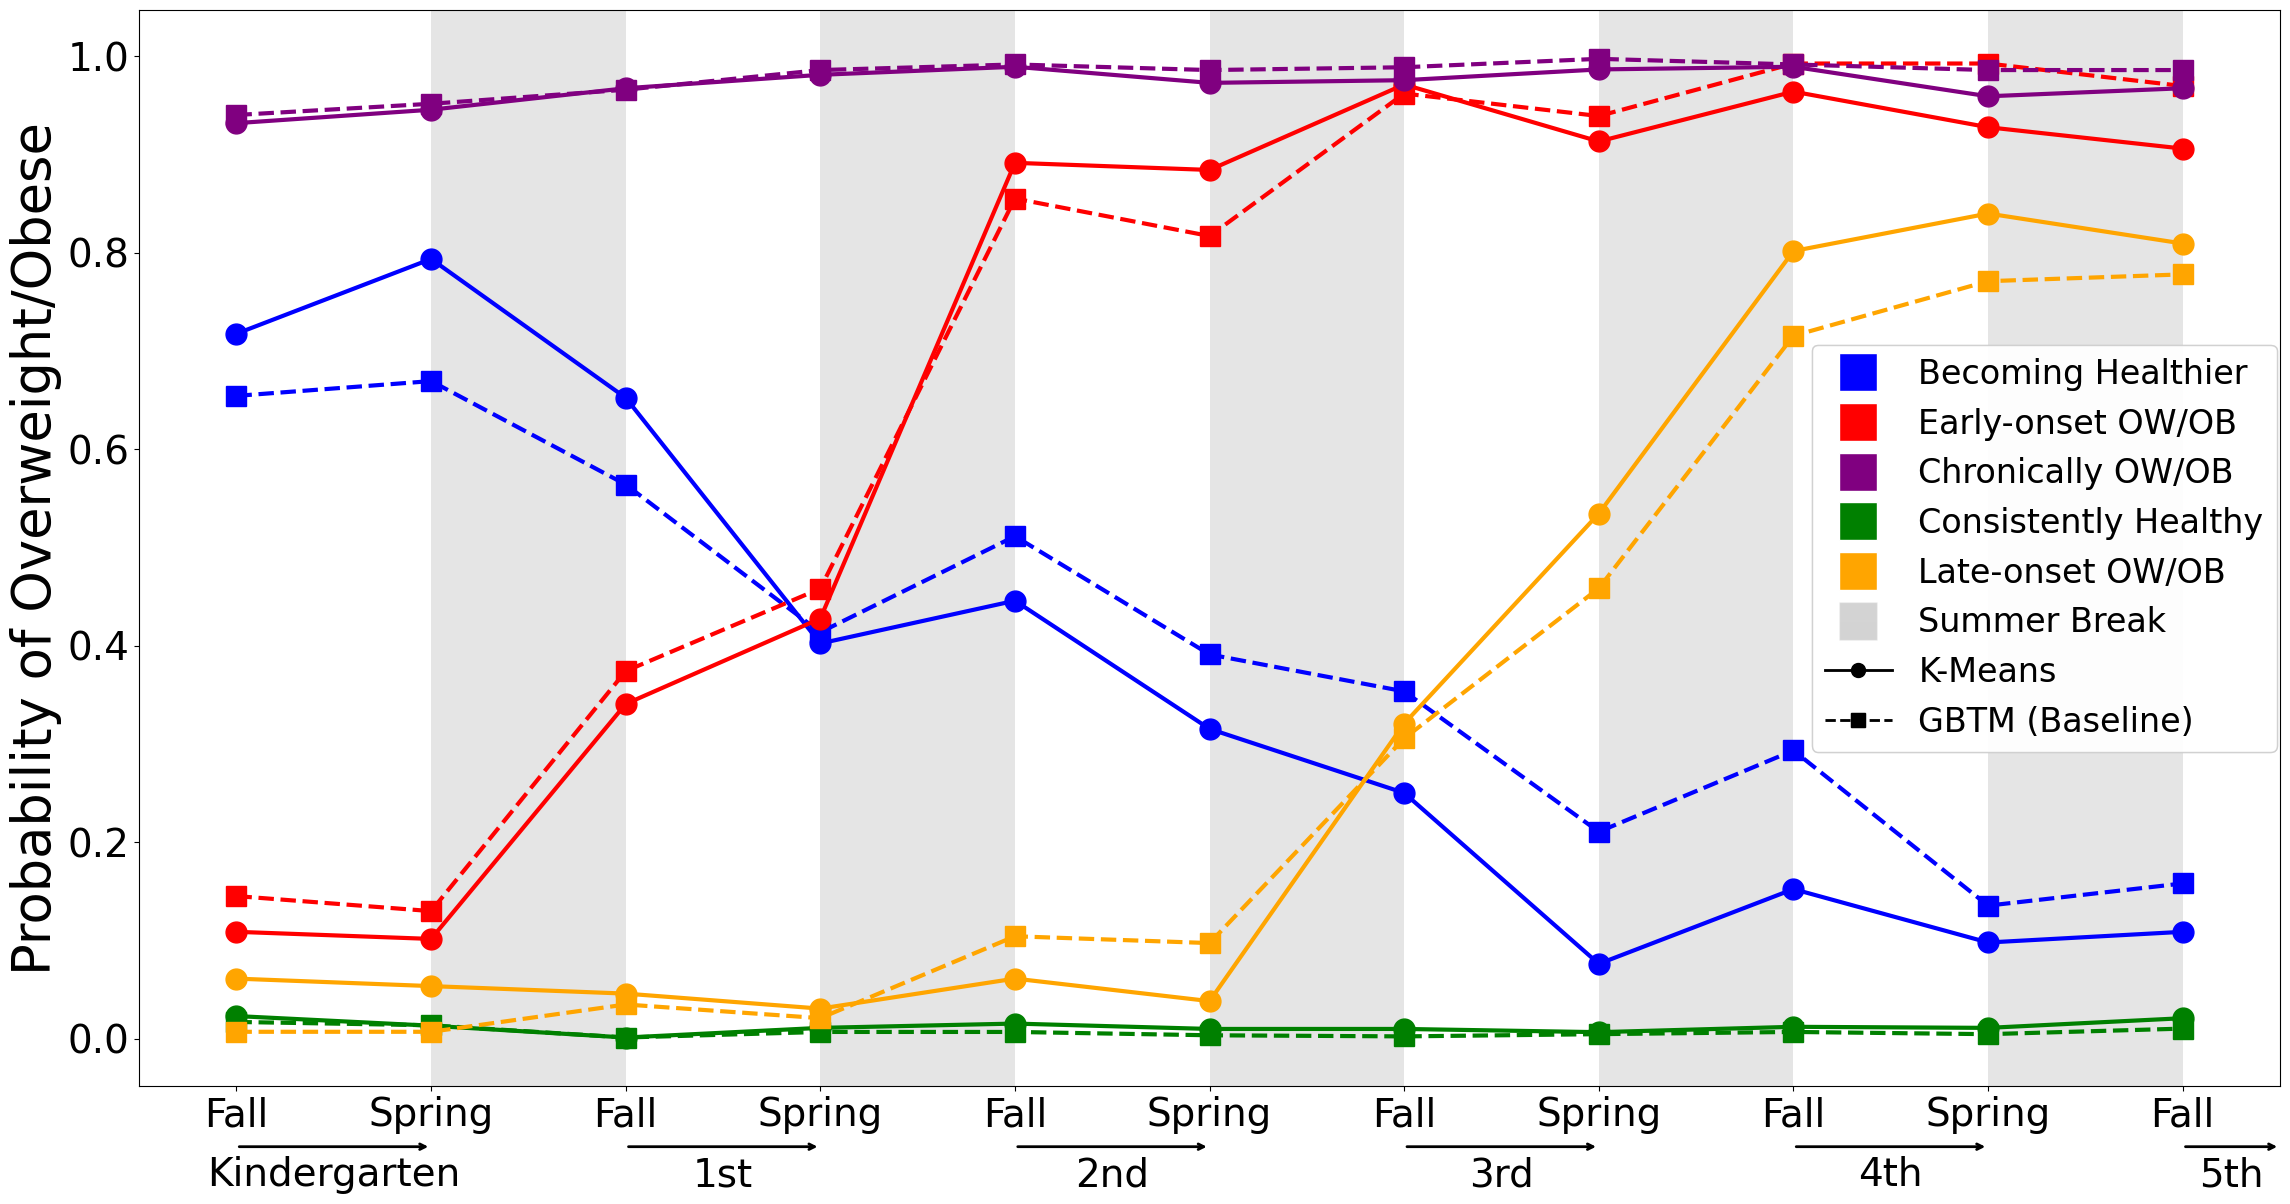

In [20]:
# plot the trajectory groups of k-means vs. GBTM
kmeans.plot_refined_trajgps(kmeans.store_trajgps(student_data))

## 2.2 Time Series Regression

In [21]:
from modeling.ts_regression.ts_sarimax_modeling import create_student_dfs, sarima_modeling, sarimax_modeling

In [22]:
# Sampling five randomly selected students
student_sample = student_data.sample(n = 5, random_state = 10)

In [23]:
# Creating a dictionary of DataFrames for each student
sample_dict = create_student_dfs(student_sample)

### SARIMA Model - Height Prediction

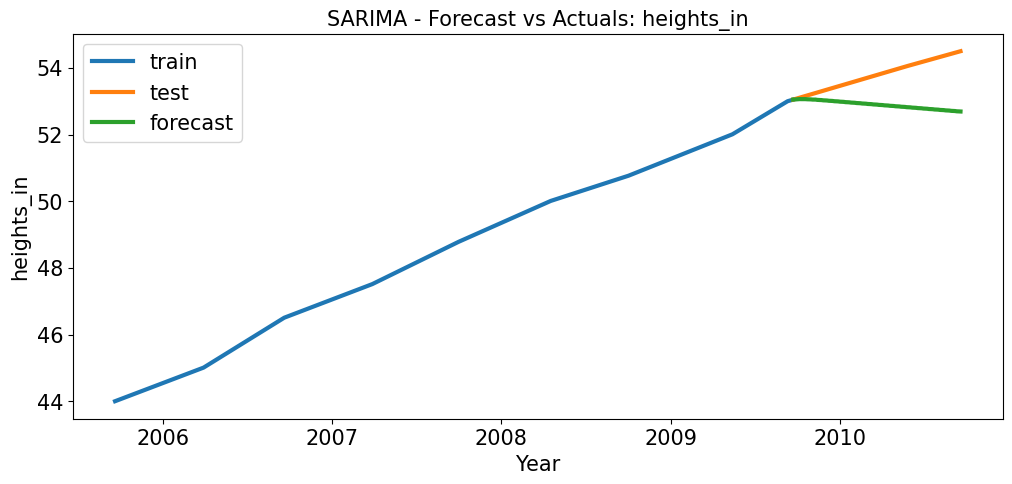

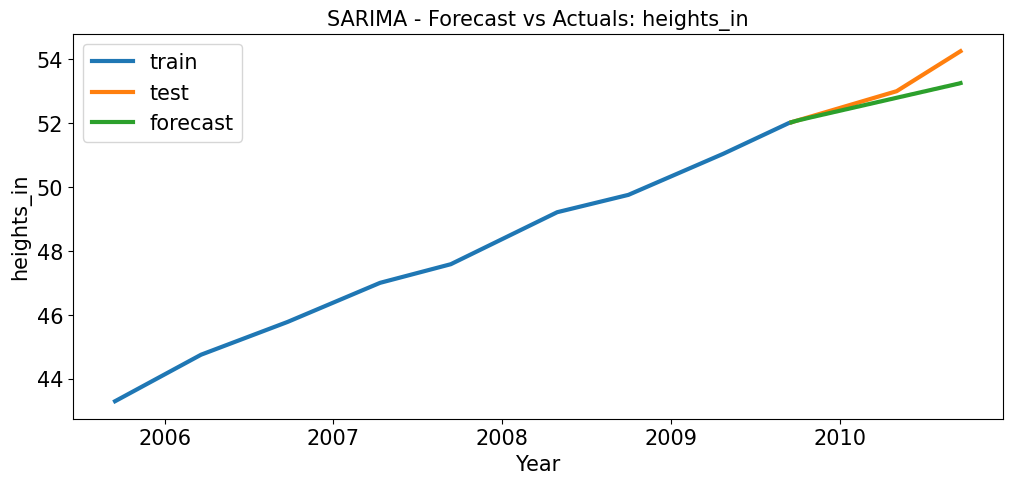

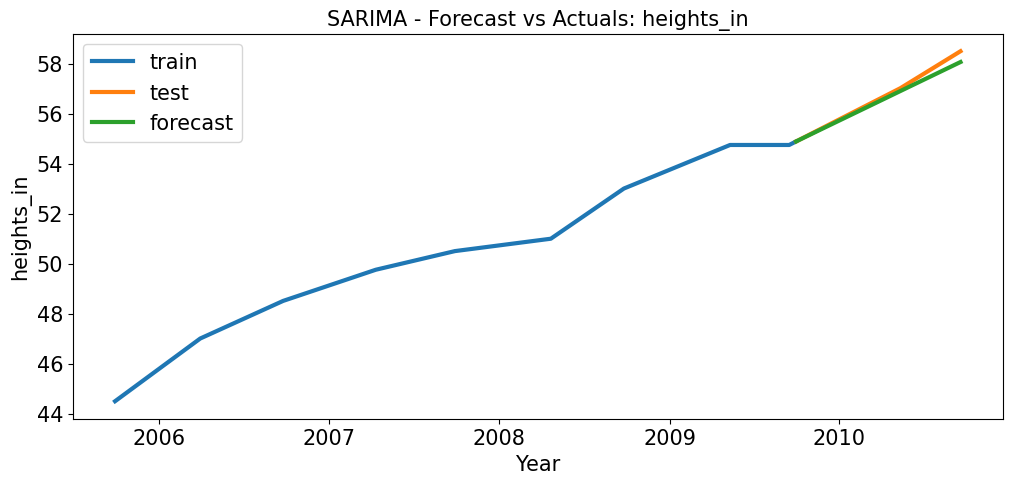

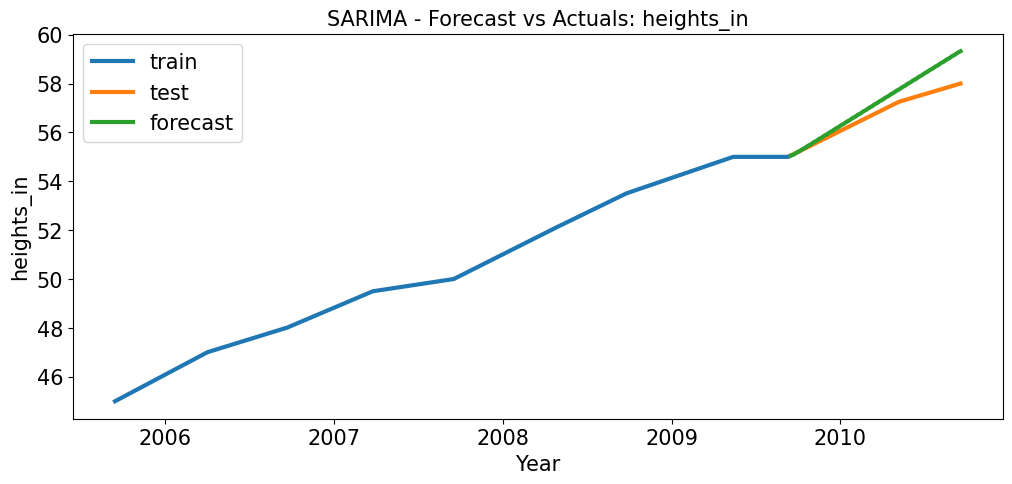

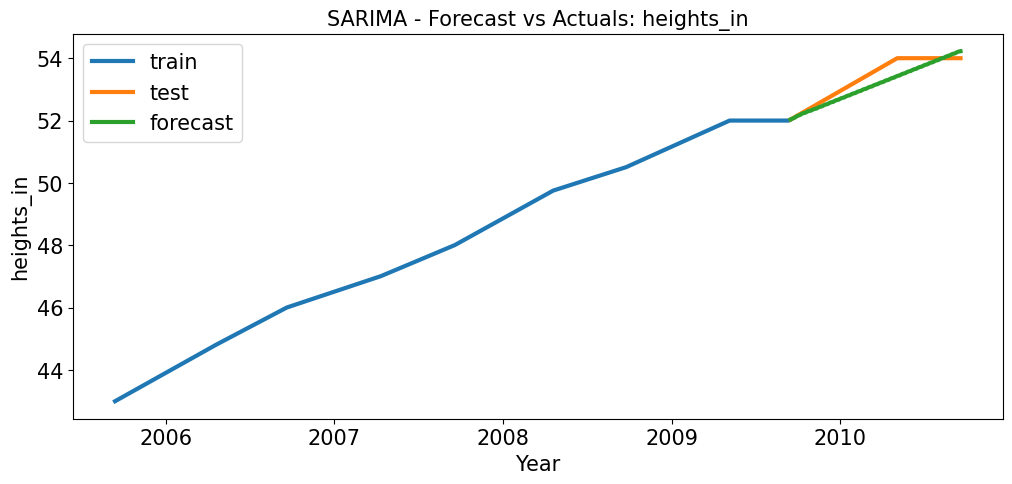

In [24]:
# Generating SARIMA model plots and evaluation metrics
sarima_metrics = sarima_modeling(sample_dict, 'heights_in')

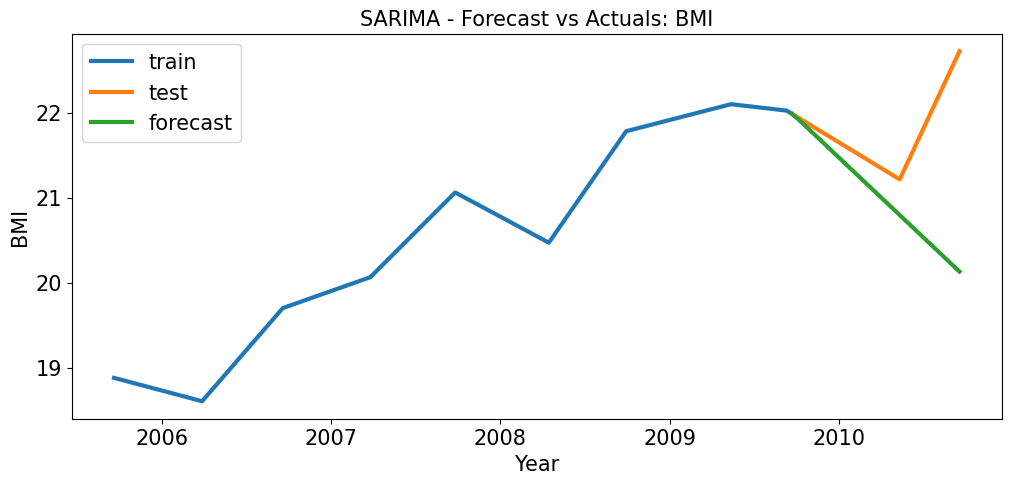

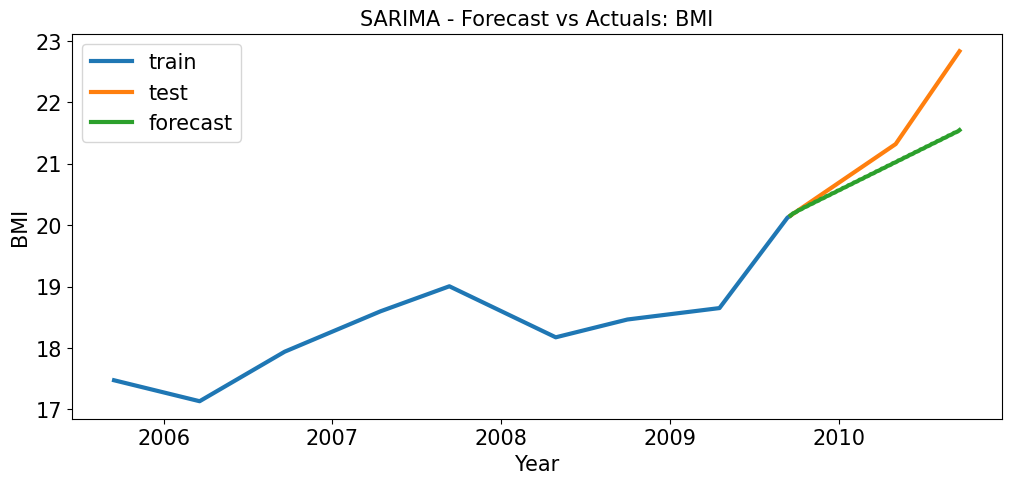

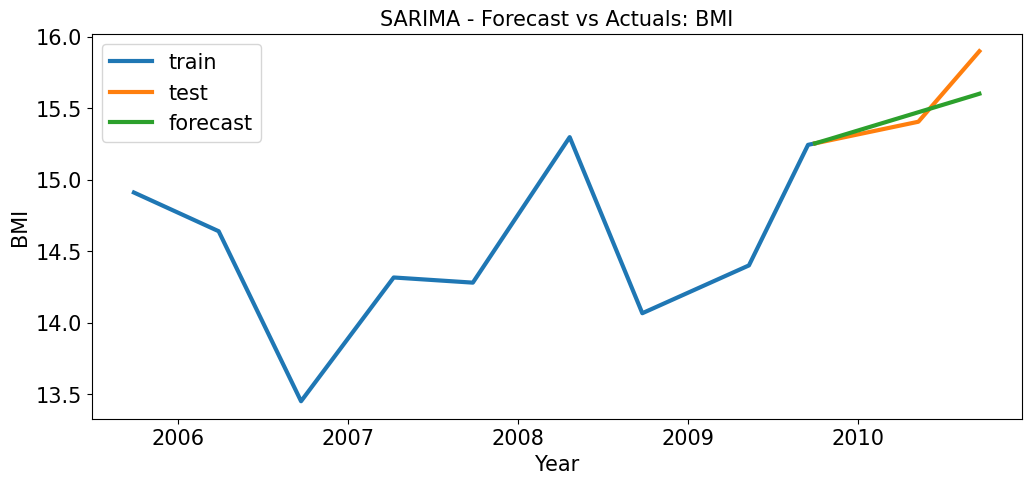

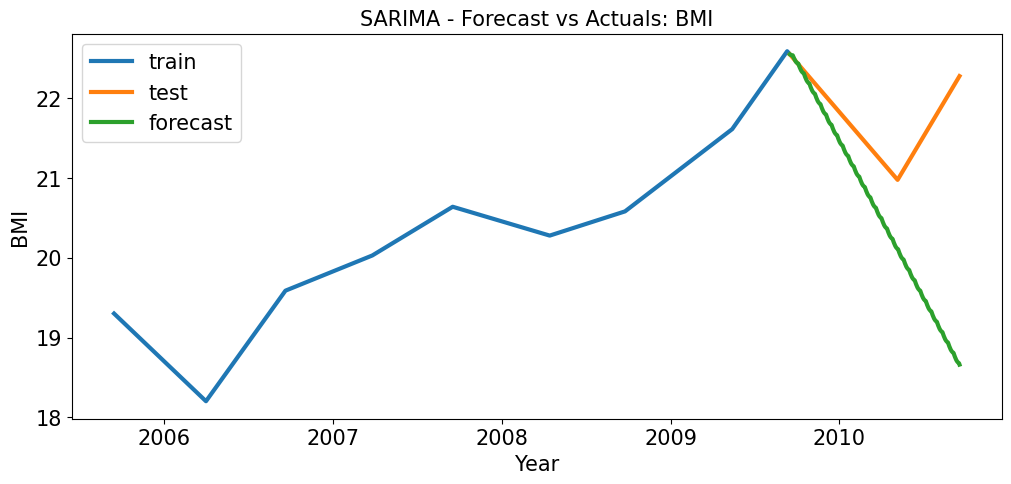

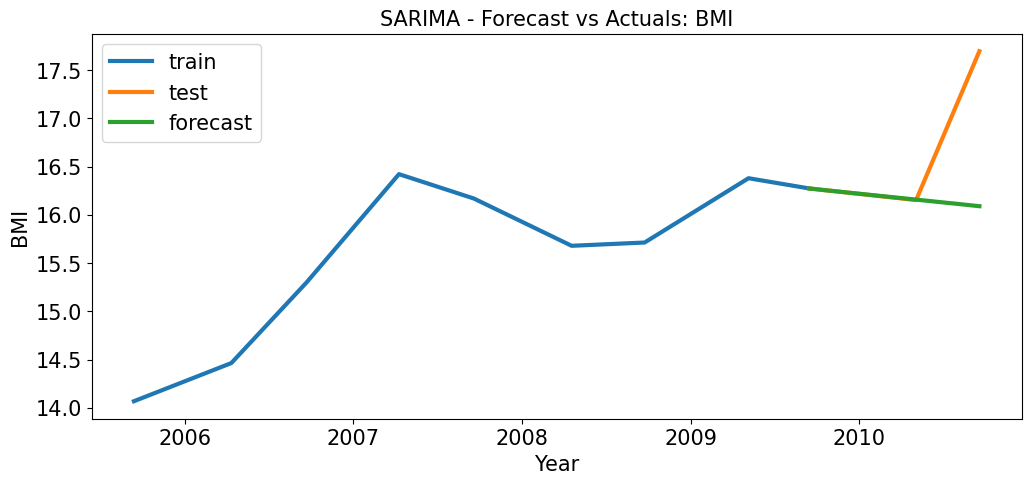

In [25]:
# Generating SARIMA model plots and evaluation metrics
sarima_metrics = sarima_modeling(sample_dict, 'BMI')

### SARIMA Model - Evaluating Model with Mean MAPE and RMSE

In [26]:
# Printing out mean MAPE and RMSE values
print("SARIMA Model: Evaluation Metrics")
print("Mean MAPE: " + str(np.mean(sarima_metrics['sarima_mape'])))
print("Mean RMSE: " + str(np.mean(sarima_metrics['sarima_rmse'])))

SARIMA Model: Evaluation Metrics
Mean MAPE: 0.02395895682989942
Mean RMSE: 0.7391340115102849


### SARIMAX Model - Height Prediction

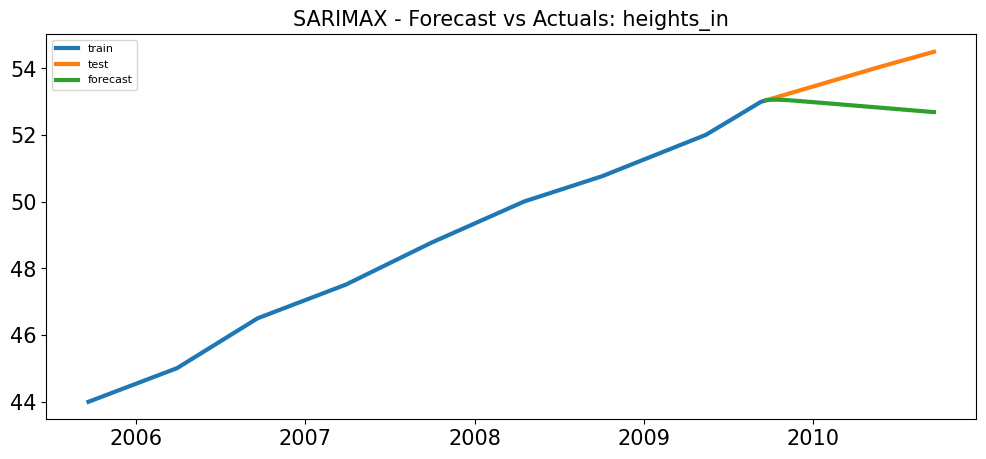

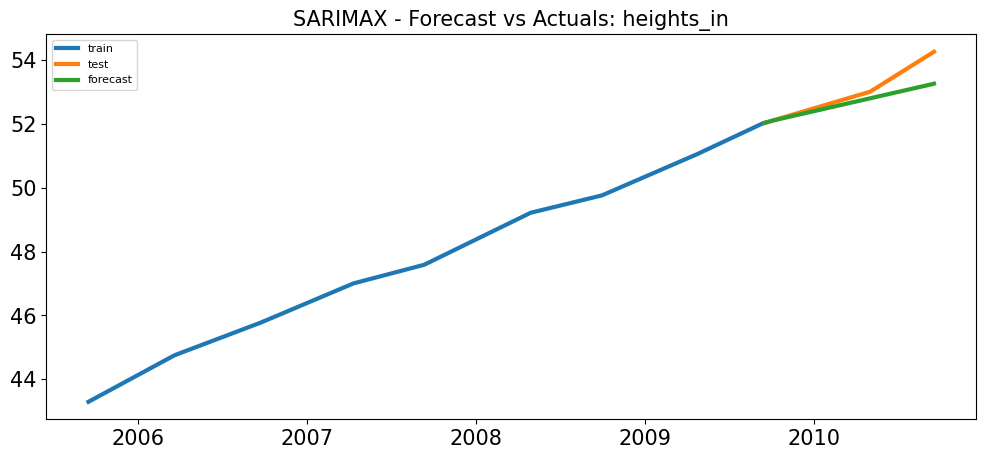

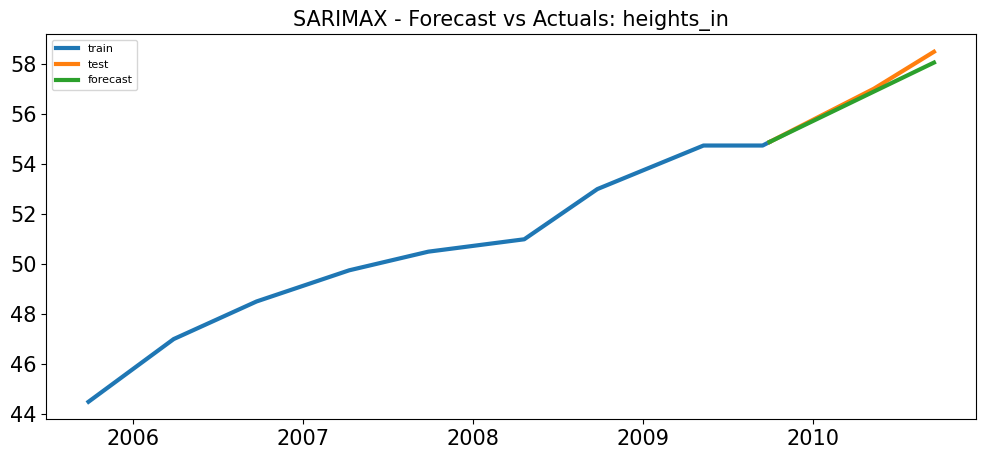

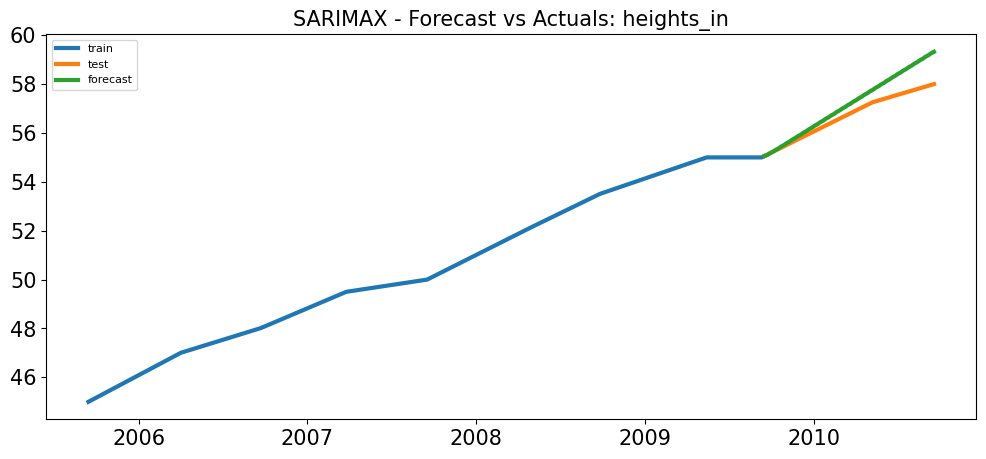

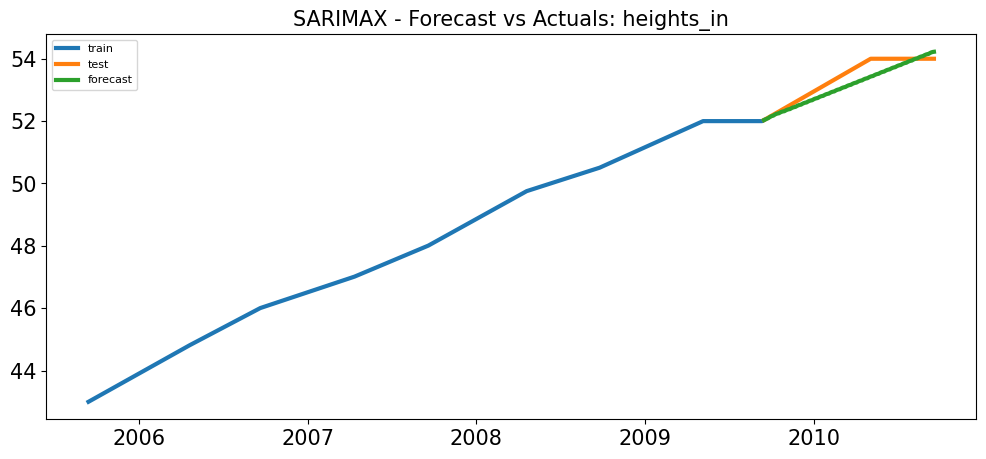

In [27]:
# Generating SARIMAX model plots and evaluation metrics
sarimax_metrics = sarimax_modeling(sample_dict, 'heights_in', 'DMSP_mean')

### SARIMAX Model - Evaluating Model with Mean MAPE and RMSE

In [28]:
# Printing out mean MAPE and RMSE values
print("SARIMAX Model (w/ DMSP_mean as exogenous variable): Evaluation Metrics")
print("Mean MAPE: " + str(np.mean(sarimax_metrics['sarimax_mape'])))
print("Mean RMSE: " + str(np.mean(sarimax_metrics['sarimax_rmse'])))

SARIMAX Model (w/ DMSP_mean as exogenous variable): Evaluation Metrics
Mean MAPE: 0.007487766758856729
Mean RMSE: 0.5107264049600286


### Prophet Model
The Prophet model is a Bayesian based curve fitting method to forecast the time series data .Whereas SARIMAX tries to build a formula for future values as a function of past values, the Prophet model tries to detect “change points.” One can think of Prophet as curve-fitting as it focuses on regressors for non-periodic trends and then periodic trends. The Prophet may do better at forecasting future BMI values.

In [32]:
from modeling.ts_regression.ts_prophet_modeling import create_student_dataframes, adjusting_df_prophet, prophet_for_height_allregressors, prophet_for_height_noregressors

In [33]:
student_sample = student_data.sample(n = 5, random_state = 10)

The following code create student dataframes that can be processed into the Prophet model. The first model created runs the prophet model using health data and all additional agressors such as COI and light data. The forecasting plots are printed out as well as the mean absolute percentage error (MAPE) for each regression

14:16:35 - cmdstanpy - INFO - Chain [1] start processing
14:16:37 - cmdstanpy - INFO - Chain [1] done processing
14:16:38 - cmdstanpy - INFO - Chain [1] start processing
14:16:41 - cmdstanpy - INFO - Chain [1] done processing
14:16:41 - cmdstanpy - INFO - Chain [1] start processing
14:16:44 - cmdstanpy - INFO - Chain [1] done processing
14:16:44 - cmdstanpy - INFO - Chain [1] start processing
14:16:46 - cmdstanpy - INFO - Chain [1] done processing
14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:49 - cmdstanpy - INFO - Chain [1] done processing


[0.01614712145106324,
 0.016348067216227318,
 0.011949568722986019,
 0.034728185238003084,
 0.014089879325013828]

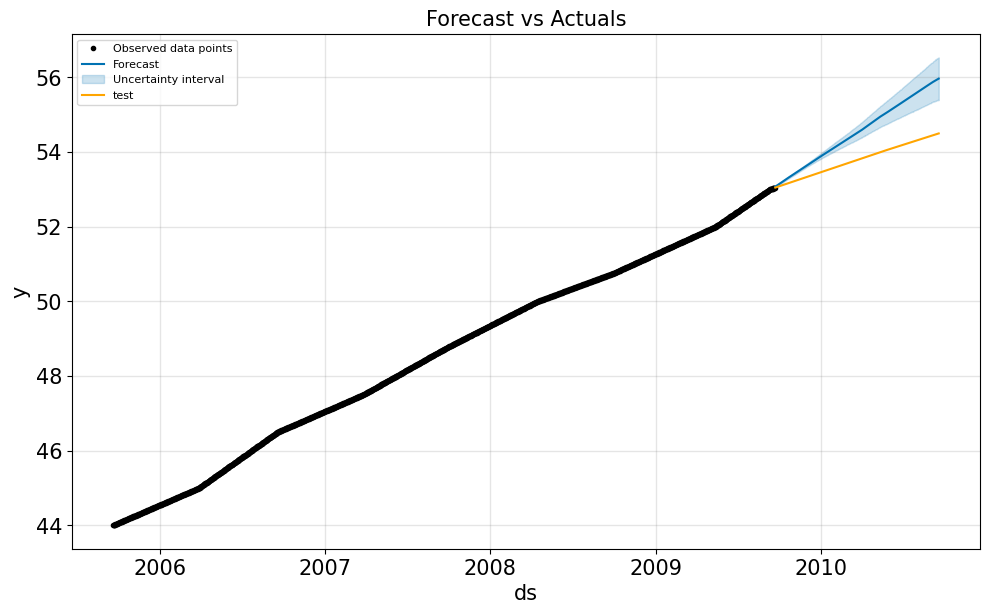

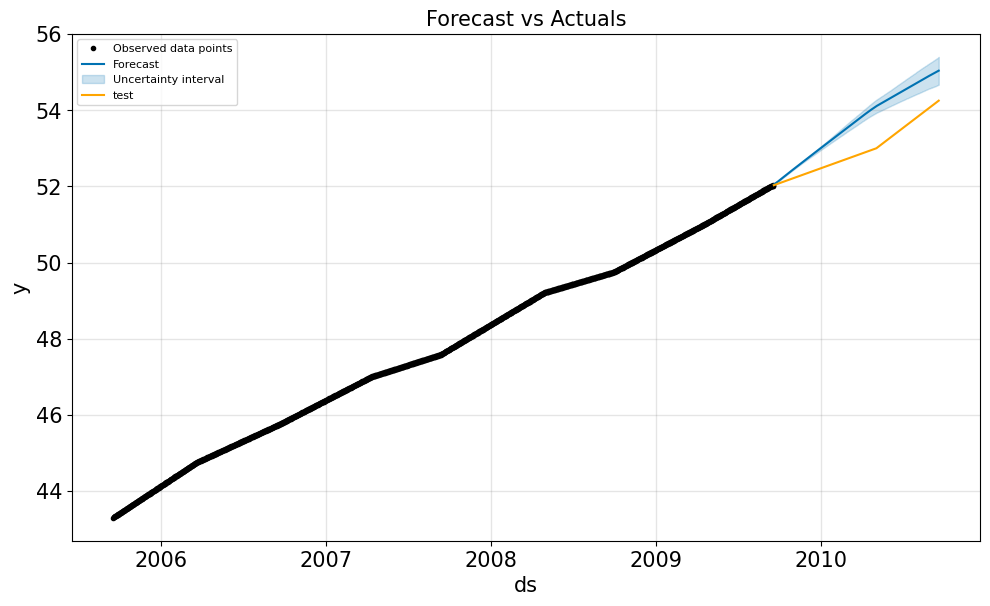

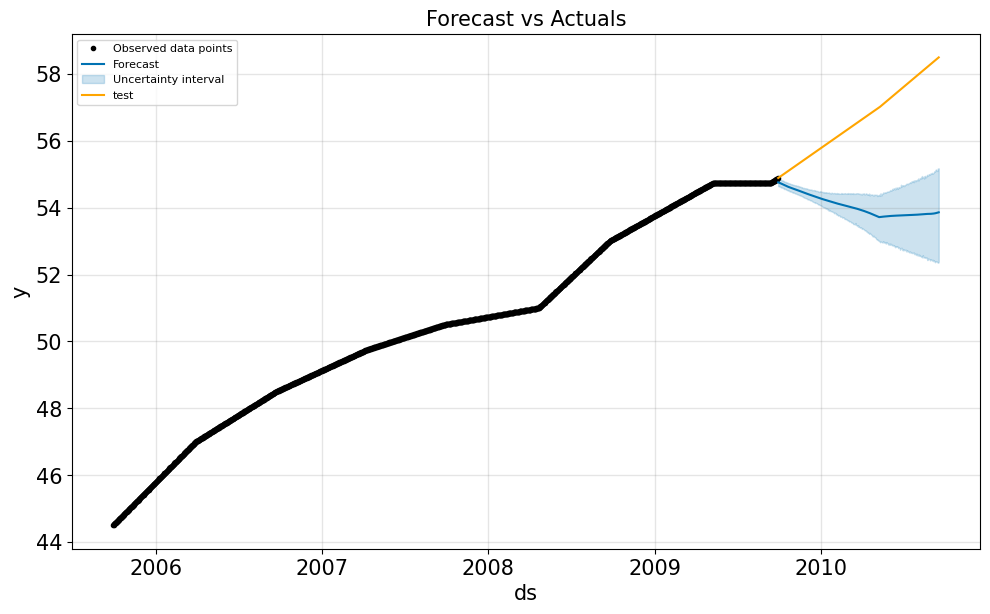

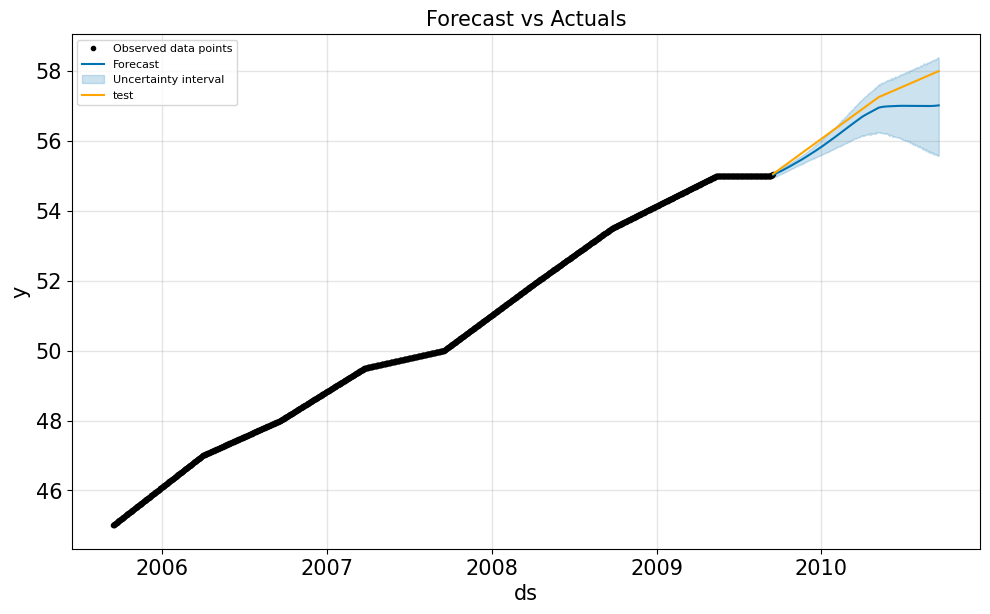

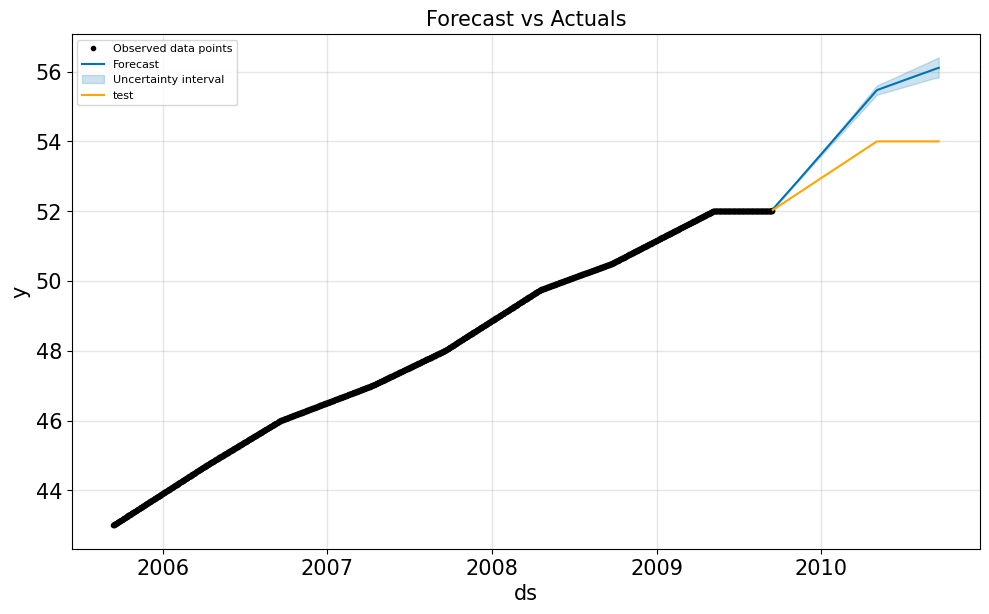

In [34]:
#Create dataframe in proper time-series format
test=create_student_dataframes(student_sample)

#Applies additional formatting due to Prophet Model Constraints
adjusting_df_prophet(test)

#Runs Prophet model with all additional regressors (COI, DMSP)
prophet_for_height_allregressors(test) 

The following code creates student dataframes that can be processed into the Prophet model. This model created runs the prophet model using health data and no additional agressors. The forecasting plots are printed out as well as the mean absolute percentage error (MAPE) for each regression

14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:54 - cmdstanpy - INFO - Chain [1] done processing
14:16:54 - cmdstanpy - INFO - Chain [1] start processing
14:16:57 - cmdstanpy - INFO - Chain [1] done processing
14:16:57 - cmdstanpy - INFO - Chain [1] start processing
14:16:59 - cmdstanpy - INFO - Chain [1] done processing
14:16:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:02 - cmdstanpy - INFO - Chain [1] done processing
14:17:03 - cmdstanpy - INFO - Chain [1] start processing
14:17:06 - cmdstanpy - INFO - Chain [1] done processing


[0.007403079484863996,
 0.006687705558497463,
 0.015233131163246318,
 0.01346388219038997,
 0.009137081417734044]

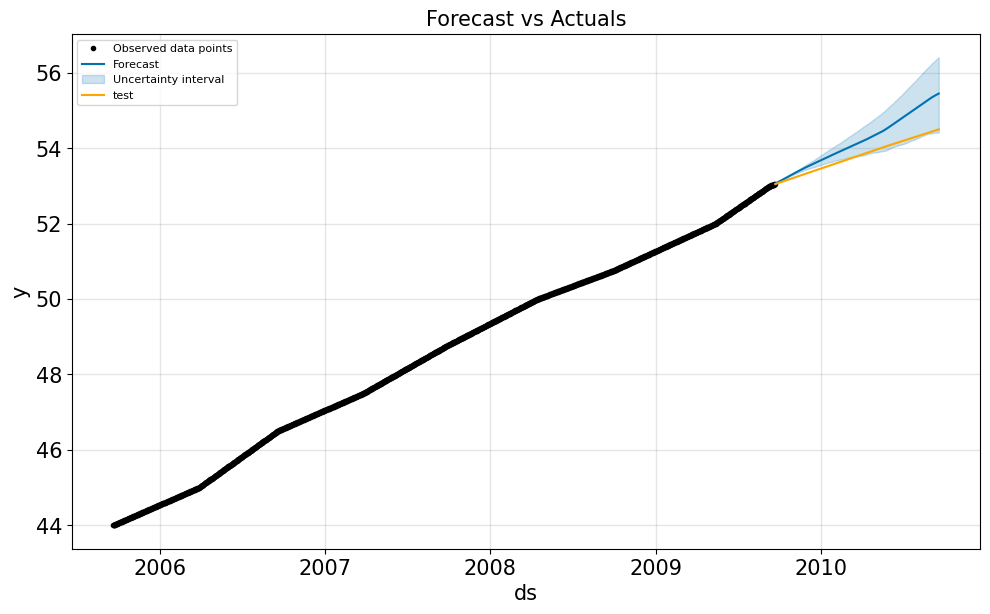

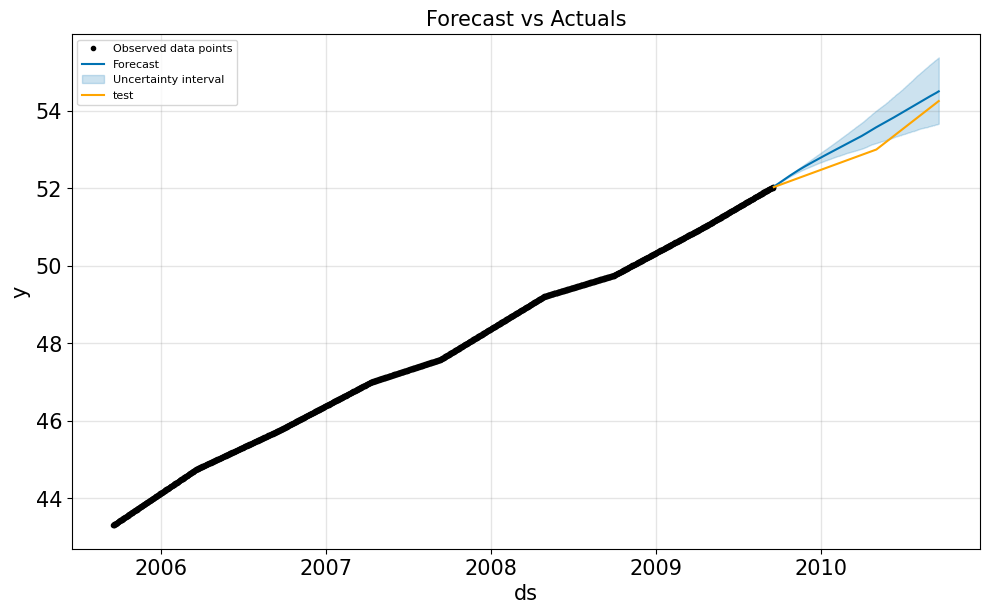

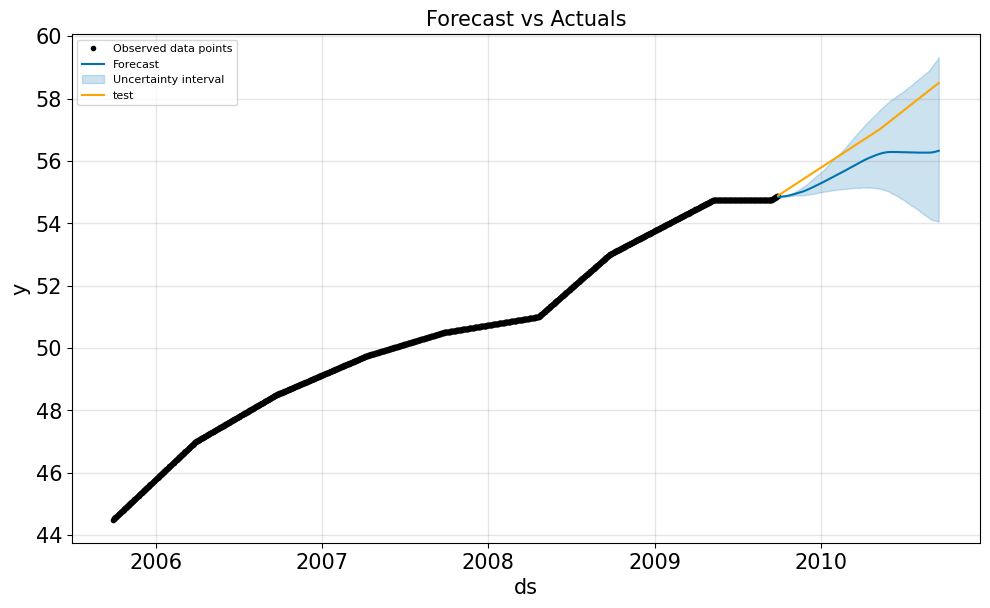

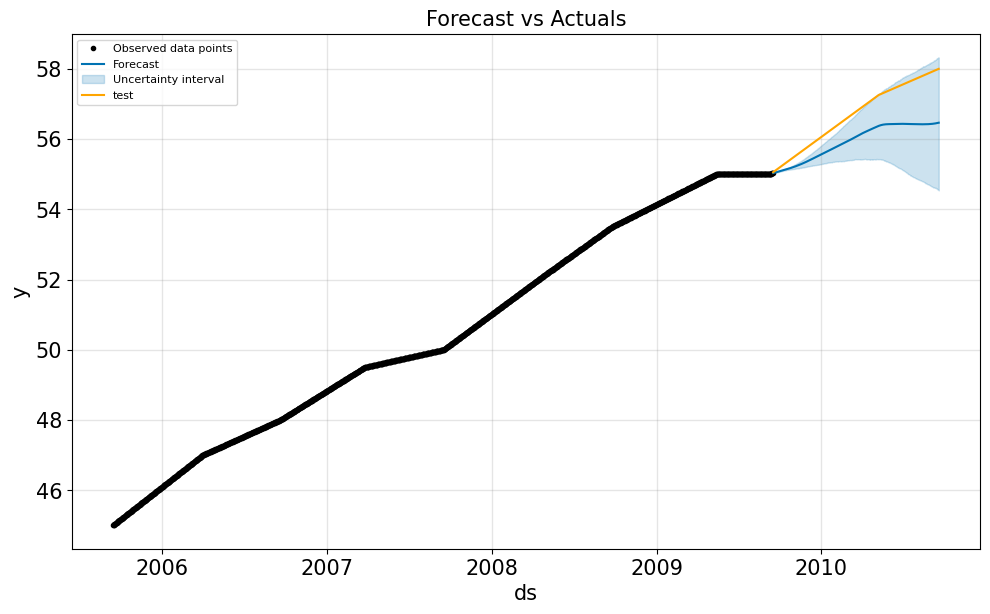

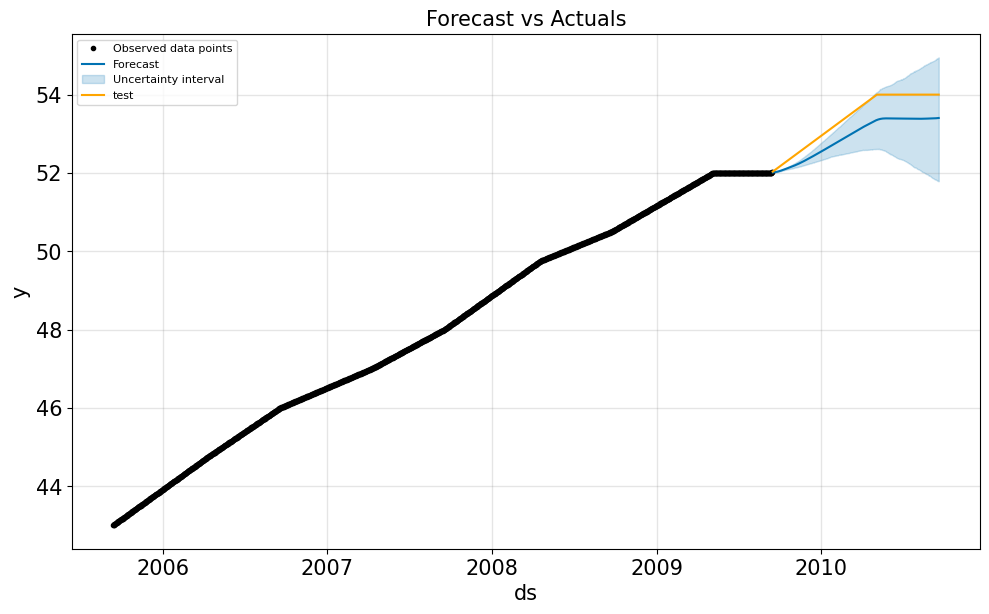

In [35]:
# Runs Prophet model with no additional regressors (No COI or DMSP)
prophet_for_height_noregressors(test)

From these models and their MAPE, we see that the prophet model that does not use the additional regressions performs better.